# College Basketball Analysis
# Group 1
# CMSE 202
#### Grayson Slansky, Quin Scott, Shubh Gorantla, Mihir Patel, Ishmail Khan

## Introduction
The aim of our project was to predict the outcome of college basketball games using historical data. We sought to answer: how can we predict the winner of a college basketball game? To tackle this, we used an NCAA dataset containing data from the past 10 seasons on key metrics such as Adjusted Offensive Efficiency (ADJOE), the average number of points scored per 100 possessions; Adjusted Defensive Efficiency (ADJDE), the average number of points surrendered per 100 defensive possessions; and postseason performance. After cleaning the dataset to ensure consistency, we focused on utilizing margins as predictors.

In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # Importing the Logistic Regression model from scikit-learn
from sklearn.metrics import accuracy_score, classification_report
from matplotlib.colors import ListedColormap # Importing ListedColormap for customizing plot colors
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report # Importing metrics to evaluate model performance
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Cleaning Data
We used multiple datasets to match team metrics with individual game data. The data provided in the game specific dataset listed each game as a pair of rows, one for each team. We reorganized it so that the higher-seeded team (better-performing) was listed first, and the lower-seeded team second. We calculated margins between these metrics, as provided by our team metrics dataset, creating new columns such as OE_margin (difference in ADJOE) and DE_margin (difference in ADJDE). Win margin, which was the points scored by the higher-seeded team minus the points scored by the lower-seeded team, served as our target variable.

##### Import Necessary Datasets

In [2]:
# Team Metrics
cbb_data = pd.read_csv('cbb.csv')
cbb_data.dropna(axis=0,inplace=True,subset='POSTSEASON') # Remove teams that did not make the March Madness Tournament
cbb_data.loc[:,'ROUND'] = 1 # Add numeric value for round reached in tournament
for i in range(len(cbb_data.loc[:,'POSTSEASON'])):
    if cbb_data.iloc[i,-4] == 'R64':
        cbb_data.iloc[i,-1] += 1
    elif cbb_data.iloc[i,-4] == 'R32':
        cbb_data.iloc[i,-1] += 2
    elif cbb_data.iloc[i,-4] == 'S16':
        cbb_data.iloc[i,-1] += 3
    elif cbb_data.iloc[i,-4] == 'E8':
        cbb_data.iloc[i,-1] += 4
    elif cbb_data.iloc[i,-4] == 'F4':
        cbb_data.iloc[i,-1] += 5
    elif cbb_data.iloc[i,-4] == '2ND':
        cbb_data.iloc[i,-1] += 6
    elif cbb_data.iloc[i,-4] == 'Champions':
        cbb_data.iloc[i,-1] += 7

cbb_data.loc[:,'ID'] = 0
for i in range(len(cbb_data.loc[:,'TEAM'])):
    cbb_data.iloc[:,-1] =i
cbb_data.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,ROUND,ID
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016,7,679
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015,7,679
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018,7,679
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019,7,679
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017,7,679


In [3]:
# Game Data
tournament_matchups = pd.read_csv('tournament_matchups.csv')
tournament_matchups.dropna(axis=0,inplace=True,subset='SCORE') # Remove games with missing score values
tournament_matchups = tournament_matchups[tournament_matchups['YEAR']>=2013] # Select years matching those present in Team Metrics
tournament_matchups.drop(inplace=True,columns = ['BY YEAR NO', 'BY ROUND NO', 'TEAM NO','ROUND']) # Remove unwanted columns
tournament_matchups.loc[:,'TEAM'] = tournament_matchups.loc[:,'TEAM'].str.strip() # Fix issues with team names
tournament_matchups.head()

,YEAR,TEAM,SEED,CURRENT ROUND,SCORE
148,2023,Alabama,1,64,96.0
149,2023,Texas A&M Corpus Chris,16,64,75.0
150,2023,Maryland,8,64,67.0
151,2023,West Virginia,9,64,65.0
152,2023,San Diego St.,5,64,63.0


##### Add Efficiency Values to Game Data

In [4]:
eff_dict = dict() # Initiate dictionary

for i in range(len(cbb_data.loc[:,'TEAM'])): # Add efficiency values to dictionary
    vals = cbb_data.iloc[i,:].values[4:-5]
    year = cbb_data.iloc[i,-3]
    team = cbb_data.iloc[i,0]
    if not year in eff_dict:
        eff_dict[year] = dict()
    if not team in eff_dict[year]:
        eff_dict[year][team] = vals

# Create variables in game dataset
tournament_matchups.loc[:,'ADJOE'] = 0
tournament_matchups.loc[:,'ADJDE'] = 0

for i in range(len(tournament_matchups.loc[:,'ADJOE'])): # Add values to new variable
    year = tournament_matchups.iloc[i,0]
    team = tournament_matchups.iloc[i,1]
    if team in eff_dict[year]:
        tournament_matchups.iloc[i,-2] = eff_dict[year][team][0]
        tournament_matchups.iloc[i,-1] = eff_dict[year][team][1]
    else: # Adjustment made for mismatched team name
        tournament_matchups.iloc[i,-2] = eff_dict[year]['Arkansas Little Rock'][0]
        tournament_matchups.iloc[i,-1] = eff_dict[year]['Arkansas Little Rock'][1]

# Create variables for other team metrics
tournament_matchups.loc[:,'BARTHAG'] = 0
tournament_matchups.loc[:,'EFG_O'] = 0
tournament_matchups.loc[:,'EFG_D'] = 0
tournament_matchups.loc[:,'TOR'] = 0
tournament_matchups.loc[:,'TORD'] = 0
tournament_matchups.loc[:,'ORB'] = 0
tournament_matchups.loc[:,'DRB'] = 0
tournament_matchups.loc[:,'FTR'] = 0
tournament_matchups.loc[:,'FTRD'] = 0
tournament_matchups.loc[:,'2P_O'] = 0
tournament_matchups.loc[:,'2P_D'] = 0
tournament_matchups.loc[:,'3P_O'] = 0
tournament_matchups.loc[:,'3P_D'] = 0
tournament_matchups.loc[:,'ADJ_T'] = 0
tournament_matchups.loc[:,'WAB'] = 0

for i in range(len(tournament_matchups.loc[:,'ADJOE'])): # Add values to new variables
    year = tournament_matchups.iloc[i,0]
    team = tournament_matchups.iloc[i,1]
    if team in eff_dict[year]:
        tournament_matchups.iloc[i,-15] = eff_dict[year][team][2]
        tournament_matchups.iloc[i,-14] = eff_dict[year][team][3]
        tournament_matchups.iloc[i,-13] = eff_dict[year][team][4]
        tournament_matchups.iloc[i,-12] = eff_dict[year][team][5]
        tournament_matchups.iloc[i,-11] = eff_dict[year][team][6]
        tournament_matchups.iloc[i,-10] = eff_dict[year][team][7]
        tournament_matchups.iloc[i,-9] = eff_dict[year][team][8]
        tournament_matchups.iloc[i,-8] = eff_dict[year][team][9]
        tournament_matchups.iloc[i,-7] = eff_dict[year][team][10]
        tournament_matchups.iloc[i,-6] = eff_dict[year][team][11]
        tournament_matchups.iloc[i,-5] = eff_dict[year][team][12]
        tournament_matchups.iloc[i,-4] = eff_dict[year][team][13]
        tournament_matchups.iloc[i,-3] = eff_dict[year][team][14]
        tournament_matchups.iloc[i,-2] = eff_dict[year][team][15]
        tournament_matchups.iloc[i,-1] = eff_dict[year][team][16]
    else: # Adjustment for mismatched team names
        tournament_matchups.iloc[i,-15] = eff_dict[year]['Arkansas Little Rock'][2]
        tournament_matchups.iloc[i,-14] = eff_dict[year]['Arkansas Little Rock'][3]
        tournament_matchups.iloc[i,-13] = eff_dict[year]['Arkansas Little Rock'][4]
        tournament_matchups.iloc[i,-12] = eff_dict[year]['Arkansas Little Rock'][5]
        tournament_matchups.iloc[i,-11] = eff_dict[year]['Arkansas Little Rock'][6]
        tournament_matchups.iloc[i,-10] = eff_dict[year]['Arkansas Little Rock'][7]
        tournament_matchups.iloc[i,-9] = eff_dict[year]['Arkansas Little Rock'][8]
        tournament_matchups.iloc[i,-8] = eff_dict[year]['Arkansas Little Rock'][9]
        tournament_matchups.iloc[i,-7] = eff_dict[year]['Arkansas Little Rock'][10]
        tournament_matchups.iloc[i,-6] = eff_dict[year]['Arkansas Little Rock'][11]
        tournament_matchups.iloc[i,-5] = eff_dict[year]['Arkansas Little Rock'][12]
        tournament_matchups.iloc[i,-4] = eff_dict[year]['Arkansas Little Rock'][13]
        tournament_matchups.iloc[i,-3] = eff_dict[year]['Arkansas Little Rock'][14]
        tournament_matchups.iloc[i,-2] = eff_dict[year]['Arkansas Little Rock'][15]
        tournament_matchups.iloc[i,-1] = eff_dict[year]['Arkansas Little Rock'][16]

tournament_matchups.head()

/tmp/ipykernel_1541782/2859257258.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '116.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tournament_matchups.iloc[i,-2] = eff_dict[year][team][0]
/tmp/ipykernel_1541782/2859257258.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '107.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tournament_matchups.iloc[i,-1] = eff_dict[year][team][1]
/tmp/ipykernel_1541782/2859257258.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9548' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tournament_matchups.iloc[i,-15] = eff_dict[year][team][2]
/tmp/ipykernel_1541782/285925

,YEAR,TEAM,SEED,CURRENT ROUND,SCORE,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,...,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
148,2023,Alabama,1,64,96.0,116.1,89.0,0.9548,52.1,41.3,...,34.2,27.9,36.6,32.6,53.8,40.8,33.5,28.3,72.6,10.2
149,2023,Texas A&M Corpus Chris,16,64,75.0,105.8,107.4,0.4566,50.5,52.6,...,32.8,27.8,34.8,38.2,48.3,54.1,36.4,33.8,68.9,-6.0
150,2023,Maryland,8,64,67.0,112.6,95.8,0.8658,50.8,47.7,...,30.0,28.1,34.3,28.4,51.8,47.4,32.8,32.3,64.3,1.0
151,2023,West Virginia,9,64,65.0,117.2,97.5,0.8933,51.5,50.9,...,34.0,29.3,39.4,38.7,50.9,50.8,35.0,34.0,68.4,1.5
152,2023,San Diego St.,5,64,63.0,110.8,89.5,0.9205,49.3,46.5,...,31.6,26.1,33.2,30.2,48.4,49.3,34.0,28.3,65.7,5.7


##### Create Team Metric Margins for Game Data

In [5]:
# Initialize variables for Offensive Efficiency and Defensive Efficiency Margins
tournament_matchups.loc[:,'OE_Margin'] = 0
tournament_matchups.loc[:,'DE_Margin'] = 0

# Add values for new margin variables, adjusted to subtract lower seed from higher seed
for i in range(len(tournament_matchups.iloc[:,0])):
    if i % 2 == 0: 
        if tournament_matchups.iloc[i,2] <= tournament_matchups.iloc[i+1,2]:
            tournament_matchups.iloc[i,-1] = tournament_matchups.iloc[i,6] - tournament_matchups.iloc[i+1,6]
            tournament_matchups.iloc[i,-2] = tournament_matchups.iloc[i,5] - tournament_matchups.iloc[i+1,5]
        else:
            tournament_matchups.iloc[i,-1] = tournament_matchups.iloc[i+1,6] - tournament_matchups.iloc[i,6]
            tournament_matchups.iloc[i,-2] = tournament_matchups.iloc[i+1,5] - tournament_matchups.iloc[i,5]
    else:
        if tournament_matchups.iloc[i,2] <= tournament_matchups.iloc[i-1,2]:
            tournament_matchups.iloc[i,-1] = tournament_matchups.iloc[i,6] - tournament_matchups.iloc[i-1,6]
            tournament_matchups.iloc[i,-2] = tournament_matchups.iloc[i,5] - tournament_matchups.iloc[i-1,5]
        else:
            tournament_matchups.iloc[i,-1] = tournament_matchups.iloc[i-1,6] - tournament_matchups.iloc[i,6]
            tournament_matchups.iloc[i,-2] = tournament_matchups.iloc[i-1,5] - tournament_matchups.iloc[i,5]

tournament_matchups.loc[:,'GAMEID'] = 0 # Add new variable for GAMEID, to be used later

# Add values for GAMEID
gameid1 = 1
gameid2 = 1
for i in range(len(tournament_matchups.iloc[:,0])):
    if i % 2 == 0:
        tournament_matchups.iloc[i,-1] = gameid1
        gameid1 += 1
    else:
        tournament_matchups.iloc[i,-1] = gameid2
        gameid2 += 1

tournament_matchups.loc[:,'Win_Margin'] = 0 # New variable initialized for score margin, higher seed score - lower seed score

# Add values for Win_Margin
for i in range(len(tournament_matchups.loc[:,'Win_Margin'])): 
    if i % 2 == 0:
        tournament_matchups.iloc[i,-1] = tournament_matchups.iloc[i,4]-tournament_matchups.iloc[i+1,4]
    else:
        tournament_matchups.iloc[i,-1] = tournament_matchups.iloc[i-1,4] - tournament_matchups.iloc[i,4]

for i in range(len(tournament_matchups.iloc[:,0])):
    if i % 2 == 0:
        if tournament_matchups.iloc[i,2] <= tournament_matchups.iloc[i+1,2]:
            tournament_matchups.iloc[i,-1] = tournament_matchups.iloc[i,4] - tournament_matchups.iloc[i+1,4]
        else:
            tournament_matchups.iloc[i,-1] = tournament_matchups.iloc[i+1,4] - tournament_matchups.iloc[i,4]
    else:
        if tournament_matchups.iloc[i,2] <= tournament_matchups.iloc[i-1,2]:
            tournament_matchups.iloc[i,-1] = tournament_matchups.iloc[i,4] - tournament_matchups.iloc[i-1,4]
        else:
            tournament_matchups.iloc[i,-1] = tournament_matchups.iloc[i-1,4] - tournament_matchups.iloc[i,4]

# Create variables and add values for remaining team metrics
col_num = 7
for col in tournament_matchups.columns[7:-4]:
    tournament_matchups.loc[:,f'{col}_Margin'] = 0
    for i in range(len(tournament_matchups.loc[:,col])):
        if i % 2 == 0:
            if tournament_matchups.iloc[i,2] <= tournament_matchups.iloc[i+1,2]:
                tournament_matchups.iloc[i,-1] = tournament_matchups.iloc[i,col_num] - tournament_matchups.iloc[i+1,col_num]
            else:
                tournament_matchups.iloc[i,-1] = tournament_matchups.iloc[i+1,col_num] - tournament_matchups.iloc[i,col_num]
        else:
            if tournament_matchups.iloc[i,2] <= tournament_matchups.iloc[i-1,2]:
                tournament_matchups.iloc[i,-1] = tournament_matchups.iloc[i,col_num] - tournament_matchups.iloc[i-1,col_num]
            else:
                tournament_matchups.iloc[i,-1] = tournament_matchups.iloc[i-1,col_num] - tournament_matchups.iloc[i,col_num]
    col_num += 1
tournament_matchups.head()

/tmp/ipykernel_1541782/470944759.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-18.400000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tournament_matchups.iloc[i,-1] = tournament_matchups.iloc[i,6] - tournament_matchups.iloc[i+1,6]
/tmp/ipykernel_1541782/470944759.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.299999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tournament_matchups.iloc[i,-2] = tournament_matchups.iloc[i,5] - tournament_matchups.iloc[i+1,5]
/tmp/ipykernel_1541782/470944759.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4982' has dtype incompatible with int64, please explicitly cast to a compatible

,YEAR,TEAM,SEED,CURRENT ROUND,SCORE,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,...,ORB_Margin,DRB_Margin,FTR_Margin,FTRD_Margin,2P_O_Margin,2P_D_Margin,3P_O_Margin,3P_D_Margin,ADJ_T_Margin,WAB_Margin
148,2023,Alabama,1,64,96.0,116.1,89.0,0.9548,52.1,41.3,...,1.4,0.1,1.8,-5.6,5.5,-13.3,-2.9,-5.5,3.7,16.2
149,2023,Texas A&M Corpus Chris,16,64,75.0,105.8,107.4,0.4566,50.5,52.6,...,1.4,0.1,1.8,-5.6,5.5,-13.3,-2.9,-5.5,3.7,16.2
150,2023,Maryland,8,64,67.0,112.6,95.8,0.8658,50.8,47.7,...,-4.0,-1.2,-5.1,-10.3,0.9,-3.4,-2.2,-1.7,-4.1,-0.5
151,2023,West Virginia,9,64,65.0,117.2,97.5,0.8933,51.5,50.9,...,-4.0,-1.2,-5.1,-10.3,0.9,-3.4,-2.2,-1.7,-4.1,-0.5
152,2023,San Diego St.,5,64,63.0,110.8,89.5,0.9205,49.3,46.5,...,-3.0,0.7,0.5,5.3,-4.1,0.2,1.0,-1.8,-5.3,4.0


##### Subset Data for Initial Visualizations

In order to further analyze our selected problem, we wanted to try and obtain a correlation from a simple initial visualization of selected features from our dataset. The code below subsets our game data with our desired features, namely Offensive Efficiency Margin, Defensive Efficiency Margin, and GAMEID. We then remove the semi-final and final rounds from our subset in order to avoid conflicts in model creation, as teams with the same seed value can be opponents in these tournament rounds. Next, duplicate values are removed from the subset, as the team name and year classifiers are dropped, so we can obtain single row values for each game.

Finally, we plot our initial visualization of Offensive Efficiency Margin vs. Defensive Efficiency Margin. A large portion of the data is clustered in and around the fourth quadrant, which is to be expected. Higher seeds generally have a higher offensive efficiency and lower defensive efficiency than their lower seeded opponents, so when margins are created, they often fall in the fourth quadrant when plotted.

/tmp/ipykernel_1541782/1761605755.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  matchups = matchups[matchups['CURRENT ROUND'] != 4][matchups['CURRENT ROUND'] != 2]


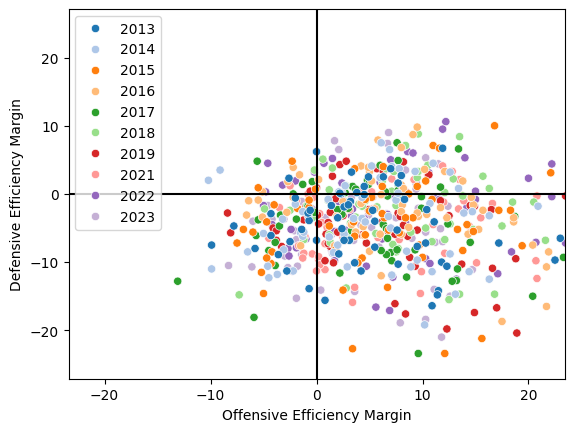

In [6]:
matchups = tournament_matchups[['YEAR','OE_Margin','DE_Margin','GAMEID','CURRENT ROUND','Win_Margin', 'BARTHAG_Margin']]
matchups = matchups[matchups['CURRENT ROUND'] != 4][matchups['CURRENT ROUND'] != 2]
matchups = matchups.drop_duplicates()

sns.scatterplot(data=matchups,x='OE_Margin',y='DE_Margin',hue='YEAR',palette='tab20')
plt.xlabel('Offensive Efficiency Margin')
plt.ylabel('Defensive Efficiency Margin')
plt.xlim(-max(abs(matchups.loc[:,'DE_Margin'])), max(abs(matchups.loc[:,'DE_Margin'])))
plt.ylim(-max(abs(matchups.loc[:,'OE_Margin'])), max(abs(matchups.loc[:,'OE_Margin'])))
plt.axvline(0,color='black')
plt.axhline(0,color='black')
plt.legend()
plt.show()

## Splitting Data

In [7]:
#First we must create a binary label class for our model 

# Create binary target variable (1 for positive margin, 0 for negative margin)
# This will be out label for our models 

matchups['Win_Margin_class'] = (matchups['Win_Margin'] > 0).astype(int)

#Displaying the dataframe with the new column in there 
matchups.head()


,YEAR,OE_Margin,DE_Margin,GAMEID,CURRENT ROUND,Win_Margin,BARTHAG_Margin,Win_Margin_class
148,2023,10.3,-18.4,1,64,21,0.4982,1
150,2023,-4.6,-1.7,2,64,2,-0.0275,1
152,2023,1.4,-8.2,3,64,6,0.1340,1
154,2023,-2.7,-10.8,4,64,-1,0.1607,0
156,2023,1.4,-6.0,5,64,9,0.0905,1


The code creates a binary variable called Win margin class, which classifies whether the win margin is positive (1) or not (0). If the Win_Margin column has values greater than zero, it is converted to integers, enabling machine learning models to predict game outcomes.

In [8]:
#Code below is separating our data into a 70/30 split, 70 to train the model and 30 to test the model
features = matchups.drop(['Win_Margin', 'Win_Margin_class'], axis = 1)
target = matchups['Win_Margin_class']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=50
)

print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training features shape: (449, 6)
Testing features shape: (150, 6)
Training labels shape: (449,)
Testing labels shape: (150,)


The dataset is divided into 75% for training and 25% for testing, using all features and the binary target variable.  This ensures the model has enough data to train effectively while setting aside a portion for fair and unbiased testing for evaluation. A fixed random_state=50 ensures the split is consistent and reproducible.

In [9]:
# Create the feature matrix (X_2) using relevant features 'OE_Margin' and 'DE_Margin'
# Create the target vector (y_2) using 'Win_Margin_class'
X_2 = matchups[['OE_Margin', 'DE_Margin']]
y_2 = matchups['Win_Margin_class']

# Split the dataset into training and testing sets
# 25% of the data will be used for testing, and a random_state ensures reproducibility
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, y_2, test_size=0.25, random_state=42)

# Print the shapes of the training and testing feature matrices and target vectors
print("Training features shape:", X2_train.shape)
print("Testing features shape:", X2_test.shape)
print("Training labels shape:", y2_train.shape)
print("Testing labels shape:", y2_test.shape)


Training features shape: (449, 2)
Testing features shape: (150, 2)
Training labels shape: (449,)
Testing labels shape: (150,)


A refined split uses only the most relevant features, OE_Margin and DE_Margin, to simplify the model's focus. Again, the data is divided into 75% training and 25% testing sets, ensuring consistency with the previous split. I then printed the shapes of the training and testing datasets to verify the split and data structure. 

## Checking P-Values for Significance

Now that we have our dataframe properly split up, its important we see which features are important and which ones aren't. The reason why we do this is because if our model includes only the significant and important features, than it will help our model only focus on the features that are important and useful to the dataset. To achieve this task, we can utilize the idea of a p-value and see which features/predictors have a p-value less than .05. This means that features is statistically significant. 

In [10]:
# Add a constant (intercept term) to the predictors in the 'matchups' DataFrame
X = sm.add_constant(matchups.drop(['Win_Margin', 'Win_Margin_class'], axis = 1))  
# Set the dependent variable 'y' as the 'Win_Margin' column from the 'matchups' DataFrame
y = matchups['Win_Margin']

# Fit an Ordinary Least Squares (OLS) regression model using the predictors (X) and response variable (y)
model = sm.OLS(y, X).fit()

# Generate and display a summary of the OLS regression results
model_summary = model.summary()
model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Win_Margin   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     57.43
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           6.49e-56
Time:                        21:06:16   Log-Likelihood:                -2270.7
No. Observations:                 599   AIC:                             4555.
Df Residuals:                     592   BIC:                             4586.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4163.7423   2912.266     -1.430      0.153   -9883.372    1555.887
YEAR               2.0559      1.439      1.429      0.154      -0.770       4.882
OE_Margin          1.1290      0.155      7.265      0.000       0.824       1.434
DE_Margin         -1.2212      0.184     -6.623      0.000      -1.583      -0.859
GAMEID             0.0387      0.026      1.497      0.135      -0.012       0.089
CURRENT ROUND      0.0188      0.032      0.596      0.552      -0.043       0.081
BARTHAG_Margin   -20.3739     10.050     -2.027      0.043     -40.111      -0.636
==============================================================================
Omnibus:                        2.517   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.284   Jarque-Bera (JB):                2.349
Skew:                          -0.112   Prob(JB):                        0.309
Kurtosis:                       3.210   Cond. No.                     1.35e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now that we have which features/predictors are statiscally signifacant and important to this dataset, lets go ahead and start picking out features and putting our models together.

## Logistic Regression Model with OE/DE

To start off, we will be creating a Logistic Regression Model with two features that were shown to be very much statistically significant. **OE_Margin** and **DE_margin** with their p-values being shown to be virtually 0.000. **OE_margin** is essentially the difference in offensive efficiency of the higher seed and the lower seed. **Offensive efficiency is a statistic that measures how many points a team scores per 100 possessions**. And DE_margin is the difference in defensive efficiency of the higher seed and the lower seed. **Defensive efficiency is the number of points a team allows per 100 possessions**. 

To help us create a **Logistic Regression Model**, we will be utilizing libraries such as **sklearn.linear_model** to help us do this. The code below will go ahead and utilize the package to create the model. It will be utilizing the training dataset to train the model and will fit it. 

Then we will take this model trained on the training dataset, and evaluate it how it handles the test dataset. We will then output the accuracy score utilizing **sklearn.metric accuracy score and classification report**.

In [11]:

# Creating an instance of the LogisticRegression model
model = LogisticRegression()
# Fitting the logistic regression model using the training data (X2_train and y2_train)
model.fit(X2_train, y2_train)

# Making predictions using the test data (X2_test)
y_pred = model.predict(X2_test)

# Printing the accuracy score of the model on the test set
print("Accuracy on test set:", accuracy_score(y2_test, y_pred))
# Printing a detailed classification report including precision, recall, and f1-score
print("Classification Report:\n", classification_report(y2_test, y_pred))


Accuracy on test set: 0.7266666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.36      0.44        44
           1       0.77      0.88      0.82       106

    accuracy                           0.73       150
   macro avg       0.66      0.62      0.63       150
weighted avg       0.70      0.73      0.71       150



From this logistic regression model, we see our **test set accuracy to be .72667**. Now lets plot out the decision boundary of the logistic regression model and see how linear separable our dataset is. This will then tell us if a logistic regression model is a good model, or should we go ahead and utilize another model.

/opt/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


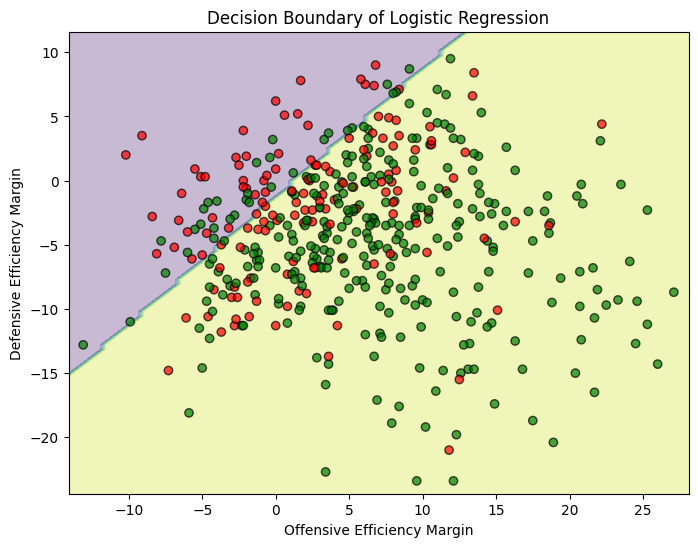

In [12]:
#NOw im going to plot to see visually if this was lienar seperable or not

#Some code below was create with assitance from Generative AI Models 
#Model: Chatgpt 40
#Prompt: How do I plot out the result of the logisits regression model

# Set the limits for the plot's x and y axes with some padding
x_min, x_max = X_2['OE_Margin'].min() - 1, X_2['OE_Margin'].max() + 1
y_min, y_max = X_2['DE_Margin'].min() - 1, X_2['DE_Margin'].max() + 1

# Create a meshgrid for plotting decision boundaries
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict the output using the trained model for each point on the grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predictions to match the shape of the meshgrid
Z = Z.reshape(xx.shape)

# Define a color map with red and green colors for the labels of negetive or positive margin 
red_green_cmap = ListedColormap(['red', 'green'])

#PLot out the Logisitc regression model along with its result 
plt.figure(figsize=(8, 6))

#Plotting out the descions boundry 
plt.contourf(xx, yy, Z, alpha=0.3)

plt.scatter(X2_train['OE_Margin'], X2_train['DE_Margin'], c = y2_train, cmap=red_green_cmap, edgecolor='k', alpha=0.7)
plt.xlabel('Offensive Efficiency Margin')
plt.ylabel('Defensive Efficiency Margin')
plt.title('Decision Boundary of Logistic Regression')
plt.show()



From this graph, we see that the datapoints aren't separable by a line. Therefore, it would be advisable that we go ahead and use a different approach to this problem. The next section tries a different model to predict the outcomes of the basketball games. 

## SVM Model with OE/DE

As we learned from our **Logistic regression Model**, our data isn't linearly separable and therefore, it isn't a good model to use. So the best option for our situation is to utilize a **Support Vector Machine** or **SVM**. We can use the **Kernel trick** to help us transform this data into a higher dimension space. Our **SVM** model here will utilize the two features, **OE_Margin** and **DE_Margin**. 

### First SVM model with C = 10

Now let's go ahead and create our very first **SVM** model by using a **C** value of 10. The kernel we chose here will be **Radial Basis Function** or **RBF**. This is because our data isn't linearly separable so the kernel will measure the distance between data points and a center, allowing it to capture highly complex relationships within the data. This can help SVMs create flexible, non-linear decision boundaries that better fit the underlying data structure. 

In [13]:
#Clearly we can see the data isn't lienarly separable, so now we should proceed with using a SVM which does work best with non linearly separable data

# Fit an SVM model with an RBF kernel
# Chose the RBF (Radial Basis Function) kernel because the data is not linearly separable.
# The RBF kernel is effective for capturing non-linear decision boundaries and complex relationships in the data.
svm_model = SVC(kernel='rbf', C=10, gamma='scale')

# Train the SVM model on the training data (X2_train features and y2_train target labels)
svm_model.fit(X2_train, y2_train)


SVC(C=10)

Now that we have created the SVM model, let's go ahead and plot out the **Training Data set** and its decision boundaries to see how it classifies between the two labels. The two labels being a **Positive Win Margin** or a **Negative Win Margin**.

In [14]:
# Create a meshgrid for visualization
# Define the minimum and maximum values for 'OE_Margin' and 'DE_Margin' with padding for better visualizationx_min, x_max = X2_train['OE_Margin'].min() - 1, X2_train['OE_Margin'].max() + 1
y_min, y_max = X2_train['DE_Margin'].min() - 1, X2_train['DE_Margin'].max() + 1

# Generate a grid of points (xx, yy) spanning the range of values for plotting
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict the classification for each point in the meshgrid using the trained SVM model
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predictions to match the shape of the meshgrid for contour plotting
Z = Z.reshape(xx.shape)

/opt/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


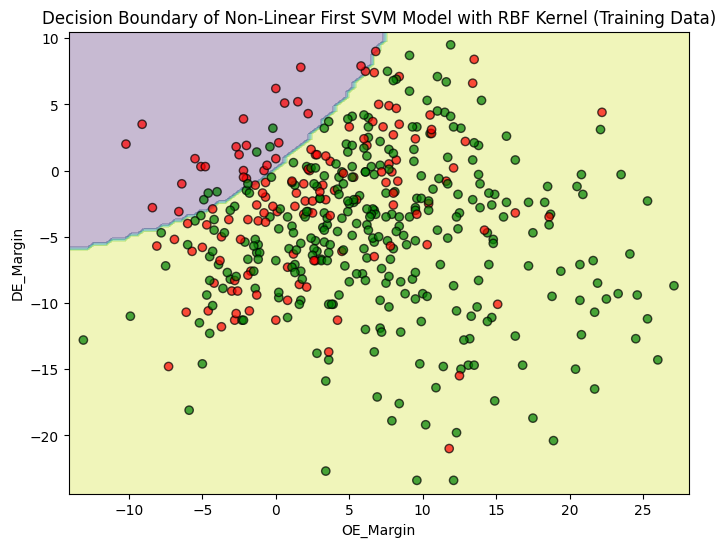

In [15]:

#Plotting out the results of the SVM model
plt.figure(figsize=(8, 6))

# Plot the decision boundary using contour plot with some transparency for better visibility
plt.contourf(xx, yy, Z, alpha=0.3)

#Created our own colormap in order to label out red and green 
red_green_cmap = ListedColormap(['red', 'green'])

# Scatter plot the training data points using 'OE_Margin' and 'DE_Margin' features
# Color the points based on their classes (y2_train) with a colormap red_green_cmap
# Add an edge color for better visibility and set alpha for transparency
plt.scatter(X2_train['OE_Margin'], X2_train['DE_Margin'], c=y2_train, edgecolor='k', cmap= red_green_cmap, alpha=0.7)

plt.xlabel('OE_Margin')
plt.ylabel('DE_Margin')
plt.title('Decision Boundary of Non-Linear First SVM Model with RBF Kernel (Training Data)')
plt.show()

From our Graph, we see that the decision boundary is working but it doesn't properly capture and separate a majority of the data points based off its labels. Lets go ahead and utilize **Grid Search** and see which parameters are the best for this SVM model. We will do this by creating a dictionary with potential parameter values and feed it into the **Grid Search Function** and have the function return the parameter values that would give us the best cross validation score. 

It's important to note what a Cross Validation score is. A **Cross Validation Score** is an accuracy score that results from a cross-validation process, which is a statistical technique used to evaluate the performance of a machine learning model. So the higher score would be the better model which would mean those parameters are the best ones we should use.

### Finding optimal parameters to create another SVM model 

In [16]:
# Define a simplified parameter grid for hyperparameter tuning of the SVM model
# Focused on exploring different values of 'C' and 'gamma' for the 'rbf' kernel
param_grid = {
    'C': [1, 10, 100],  # Regularization parameter values to try (controls trade-off between error and margin width)
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],  # Values for the kernel coefficient (controls influence of single training examples)
    'kernel': ['rbf'],  # Only considering the 'rbf' kernel in this grid search
}

# Create an SVM model instance for training
svm_model = SVC()

# Use GridSearchCV to perform an exhaustive search over the parameter grid with 5-fold cross-validation
grid_search = GridSearchCV(svm_model, param_grid, cv=5)

# Fit the GridSearchCV object on the training data to find the best combination of parameters
grid_search.fit(X2_train, y2_train)

# Print the best parameters found by the grid search
print("Best parameters:", grid_search.best_params_)

# Print the best cross-validation score achieved during the grid search
print("Best cross-validation score:", grid_search.best_score_)



Best parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.7238451935081148


/opt/miniconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Alright so the best cross validation score we get is **0.7238**. Now lets go ahead and create the new SVM model with these parameters given by the grid search.

### Second SVM model with C = 1 and Gamma = 1

In [17]:
# Fit an SVM model with an RBF kernel
# Create a new instance of an SVM classifier with an RBF kernel
# Set 'C' to 1 (regularization parameter) and 'gamma' to 1 (kernel coefficient) based on the values given by the gridsearch 
svm_model2 = SVC(kernel='rbf', C=1, gamma=1)

# Train the SVM model on the training data using 'OE_Margin' and 'DE_Margin' features (X2_train) and labels (y2_train)
svm_model2.fit(X2_train, y2_train)


SVC(C=1, gamma=1)

Ok, now lets take this new SMV model graph the new decision boundry that is created with these given paramters.

In [18]:
# Create a meshgrid for visualization
# Define the minimum and maximum values for 'OE_Margin' and 'DE_Margin' with padding to ensure better visualization
x_min, x_max = X2_train['OE_Margin'].min() - 1, X2_train['OE_Margin'].max() + 1
y_min, y_max = X2_train['DE_Margin'].min() - 1, X2_train['DE_Margin'].max() + 1

# Generate a grid of points (xx, yy) spanning the range of values for plotting the decision boundary
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict the class for each point on the meshgrid using the trained SVM model (svm_model2)
Z2 = svm_model2.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predicted labels to match the shape of the meshgrid for contour plotting
Z2 = Z2.reshape(xx.shape)


/opt/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


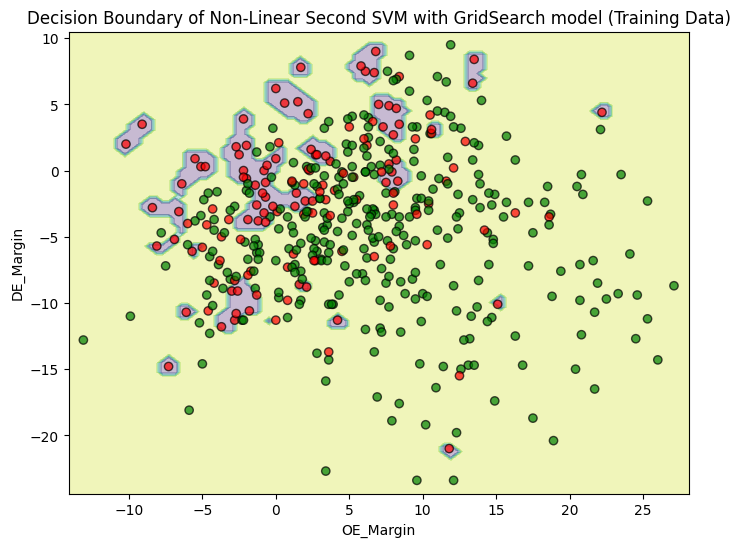

In [19]:
# Create a new plot figure with specified size
plt.figure(figsize=(8, 6))

# Plot the decision boundary using contour plot, with some transparency for better visibility
plt.contourf(xx, yy, Z2, alpha=0.3)

# Scatter plot the training data points using 'OE_Margin' and 'DE_Margin' features
# Color the points based on their classes (y2_train) using the 'viridis' colormap
# Add a black edge color for better visibility of data points and set alpha for transparency
plt.scatter(X2_train['OE_Margin'], X2_train['DE_Margin'], c=y2_train, edgecolor='k', cmap=red_green_cmap, alpha=0.7)

# Label the x-axis and y-axis
plt.xlabel('OE_Margin')
plt.ylabel('DE_Margin')

# Add a title to the plot to indicate this visualization is for the second SVM model trained with GridSearch parameters
plt.title('Decision Boundary of Non-Linear Second SVM with GridSearch model (Training Data)')

# Display the plot
plt.show()


That looks a lot better decision boundary. It looks like it actually classifies properly most of the negative win margins. Lets now go ahead and try this trained model on the test dataset and see how it preforms. Keep in mind, this SVM model has never seen the test data set. So it will be interesting to see what the test accuracy score gives us. 

In [20]:
#Now lets test the data on the test dataset 

# Get the best model from GridSearchCV after hyperparameter tuning
best_model = grid_search.best_estimator_

# Make predictions on the test dataset using the best model
y2_pred = best_model.predict(X2_test)

# Evaluate the model's performance on the test set by calculating the accuracy score
test_accuracy = accuracy_score(y2_test, y2_pred)
print("Test set accuracy:", test_accuracy)

# Print a detailed classification report on the test set, including metrics such as precision, recall, and F1-score
print("Classification Report on Test Set:\n", classification_report(y2_test, y2_pred))


Test set accuracy: 0.7333333333333333
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.60      0.27      0.38        44
           1       0.75      0.92      0.83       106

    accuracy                           0.73       150
   macro avg       0.68      0.60      0.60       150
weighted avg       0.71      0.73      0.70       150



So it looks like our test set accuracy came out to be 73% which is not bad and not also necessarily the best. Let's go ahead and see the decision boundary the model made on the test dataset. 

/opt/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


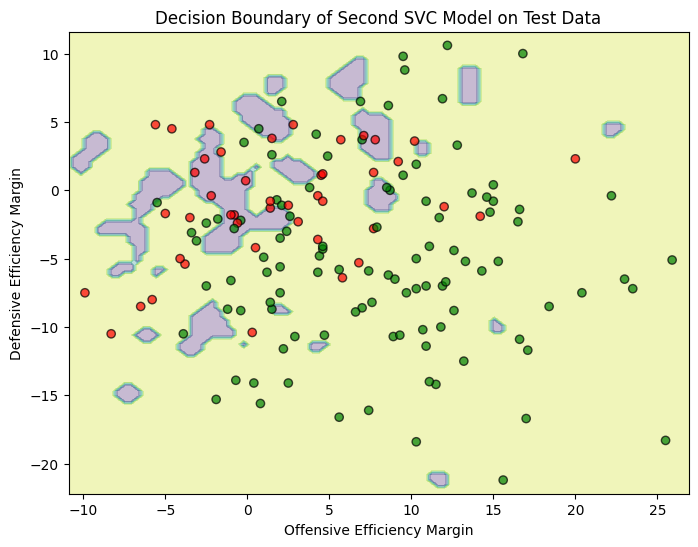

In [21]:
# Define the plotting range for 'OE_Margin' and 'DE_Margin' on the test data with padding
x_min, x_max = X2_test['OE_Margin'].min() - 1, X2_test['OE_Margin'].max() + 1
y_min, y_max = X2_test['DE_Margin'].min() - 1, X2_test['DE_Margin'].max() + 1

# Create a meshgrid of points spanning the range of test data features
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict the class for each point in the meshgrid using the best model
Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape predictions to match the shape of the meshgrid for contour plotting
Z = Z.reshape(xx.shape)

# Create a new plot figure
plt.figure(figsize=(8, 6))

# Plot the decision boundary using a contour plot with some transparency
plt.contourf(xx, yy, Z, alpha=0.3)

# Scatter plot the test data points using 'OE_Margin' and 'DE_Margin' features
# Color the points based on their true labels (y2_test) with a colormap 'viridis'
plt.scatter(X2_test['OE_Margin'], X2_test['DE_Margin'], c=y2_test, edgecolor='k', cmap=red_green_cmap, alpha=0.7)

# Label the axes
plt.xlabel('Offensive Efficiency Margin')
plt.ylabel('Defensive Efficiency Margin')

# Add a title indicating this visualization is for the test data
plt.title('Decision Boundary of Second SVC Model on Test Data')

# Display the plot
plt.show()


It looks like the decision boundary for this dataset has managed separate a little bit of the datapoints correctly, but there a good chunk of other datapoints that have not been separated. Let's go ahead and create another SVM model but this time with more options for parameters. This can help us see if we can take one more shot at making this SMV model a lot better. 

### Finding new parameters for a Third SVM model

In [22]:
# Define a larger parameter grid to explore more options for hyperparameter tuning
# Includes a wider range of values for 'C' (regularization parameter) and 'gamma' (kernel coefficient) for the 'rbf' kernel
param_dist = {
    'C': [0.1, 1, 10, 50, 100, 1000],  # Expanded range for 'C' to balance complexity vs. error margin
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'scale'],  # Expanded range for 'gamma' to control the influence of training samples
    'kernel': ['rbf'],  # Only considering the 'rbf' kernel
}

# Perform a grid search using the SVM model with the expanded parameter grid and 5-fold cross-validation
grid_search2 = GridSearchCV(svm_model, param_dist, cv=5)

# Fit the grid search object to the training data
grid_search2.fit(X2_train, y2_train)

# Print the best parameters found from the randomized search
print("Best parameters from randomized search:", grid_search2.best_params_)

# Print the best cross-validation score achieved during the grid search
print("Best cross-validation score from randomized search:", grid_search2.best_score_)


Best parameters from randomized search: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score from randomized search: 0.7304369538077403


Now it looks like the best parameters have changed and our cross validation score has increased from **.72** to **.73**. Not a huge increase, but the jump does show that the model is a little better. Now lets go ahead and train our model using the training dataset. 

### Third SVM model with C = 10 and Gamma = .001

In [23]:
# Create a new SVM model instance with an RBF kernel
# Set 'C' to 10 and 'gamma' to 0.001 based on selected/optimized values
svm_model3 = SVC(kernel='rbf', C=10, gamma=0.001)

# Train the new SVM model on the training data using 'OE_Margin' and 'DE_Margin' features (X2_train) and target labels (y2_train)
svm_model3.fit(X2_train, y2_train)


SVC(C=10, gamma=0.001)

Now, let go ahead and utilize the test dataset to test out this new SVM model and see if it has improved on its test set accuracy. 

In [24]:
#Im going to test on the test dataset directly now using this third svm model 

# Predict the labels for the test data using the newly trained SVM model (svm_model3)
y2_pred = svm_model3.predict(X2_test)

# Calculate and print the accuracy of the model on the test dataset
test_accuracy = accuracy_score(y2_test, y2_pred)
print("Test set accuracy:", test_accuracy)

# Print a detailed classification report on the test set
# This report includes metrics such as precision, recall, F1-score, and support for each class
print("Classification Report on Test Set:\n", classification_report(y2_test, y2_pred))



Test set accuracy: 0.7533333333333333
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.71      0.27      0.39        44
           1       0.76      0.95      0.85       106

    accuracy                           0.75       150
   macro avg       0.73      0.61      0.62       150
weighted avg       0.74      0.75      0.71       150



Hooray! The test set accuracy has gone up from **73%** to **75%** which is a 2 percent jump. This a good step in the right direction. Let's go ahead and see the new decision boundary our Third SVM model made and visually see the improvements and how it classified the points. 

/opt/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


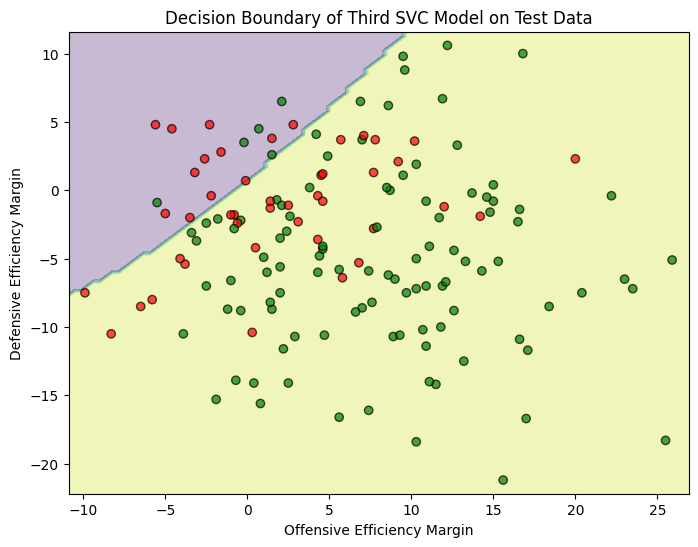

In [25]:
# Predict the class for each point in the meshgrid using the third SVM model (svm_model3)
Z = svm_model3.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape predictions to match the shape of the meshgrid for contour plotting
Z = Z.reshape(xx.shape)

# Plotting the decision boundary
plt.figure(figsize=(8, 6))  # Create a new plot figure with specified size

# Plot the decision boundary using contour plot with some transparency
plt.contourf(xx, yy, Z, alpha=0.3)

# Scatter plot the test data points using 'OE_Margin' and 'DE_Margin' features
# Color the points based on their true labels (y2_test) using the 'viridis' colormap
# Add a black edge color for better visibility and set alpha for transparency
plt.scatter(X2_test['OE_Margin'], X2_test['DE_Margin'], c=y2_test, edgecolor='k', cmap= red_green_cmap, alpha=0.7)

# Label the axes
plt.xlabel('Offensive Efficiency Margin')
plt.ylabel('Defensive Efficiency Margin')

# Add a title indicating this visualization is for the third SVC model on test data
plt.title('Decision Boundary of Third SVC Model on Test Data')

# Display the plot
plt.show()


In Conclusion, we see that our Third SVM model had better results and improved with its cross validation score increasing by 1 percent and the test set accuracy going up by 2 percent. Overall, our SMV model with these 2 feature does an alright job at predicting the outcome of the basketball game by classifying the game margins as positive or negative. With positive meaning that the higher seed team won and negative win margin meaning that the lower seed team won. 

Now, lets see if we add a third feature into an SVM model, does that increase our test set accuracy and cross validation score? That's what the next section will cover.

## SVM Model with OE/DE/BARTHAG

In [26]:
# Prepare the feature set including BARTHAG_Margin and the target variable
X_significance = matchups[['OE_Margin', 'DE_Margin', 'BARTHAG_Margin']]
X_significance = sm.add_constant(X_significance)  # Add constant for intercept
y_significance = matchups['Win_Margin_class']

# Fit a logistic regression model
logit_model = sm.Logit(y_significance, X_significance)
result = logit_model.fit()

# Print the summary to check p-values
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.511247
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       Win_Margin_class   No. Observations:                  599
Model:                          Logit   Df Residuals:                      595
Method:                           MLE   Df Model:                            3
Date:                Tue, 19 Nov 2024   Pseudo R-squ.:                  0.1675
Time:                        21:06:21   Log-Likelihood:                -306.24
converged:                       True   LL-Null:                       -367.84
Covariance Type:            nonrobust   LLR p-value:                 1.581e-26
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.2636      0.138     -1.907      0.057      -0.535       0.007
OE_Margin        

We prepared the feature set by selecting OE_Margin, DE_Margin, and BARTHAG_Margin, along with the target variable Win_Margin_class. We used StatsModels to fit a logistic regression model and print its summary to examine feature significance through p-values. This helps us decide which features to keep in subsequent models.

In [27]:
# Copy the dataset to avoid altering the original
copy_matchups = matchups.copy()

# Add the binary target variable
copy_matchups['Win_Margin_class'] = (copy_matchups['Win_Margin'] > 0).astype(int)

Here, we copied the dataset to avoid modifying the original and create a binary target variable (Win_Margin_class) to classify games as wins or losses.

In [28]:
X_3 = copy_matchups[['OE_Margin', 'DE_Margin', 'BARTHAG_Margin']]
y_3 = copy_matchups['Win_Margin']
X3_train, X3_test, y3_train, y3_test = train_test_split(X_3, y_3, test_size=0.25, random_state=42)

print("Training features shape:", X3_train.shape)
print("Testing features shape:", X3_test.shape)
print("Training labels shape:", y3_train.shape)
print("Testing labels shape:", y3_test.shape)

Training features shape: (449, 3)
Testing features shape: (150, 3)
Training labels shape: (449,)
Testing labels shape: (150,)


In this step, we split the dataset into training and testing sets, using OE_Margin, DE_Margin, and BARTHAG_Margin as features. We allocate 75% of the data for training and 25% for testing. This ensures we have a balanced dataset for training the model and evaluating its performance.

In [29]:
# Train the SVM model with the updated features
svm_model3 = SVC(kernel='rbf', C=10, gamma=0.001)
svm_model3.fit(X3_train, y3_train)

SVC(C=10, gamma=0.001)

Here, we train an SVM model with the rbf kernel, using the features OE_Margin, DE_Margin, and BARTHAG_Margin. We set specific hyperparameters (C=10, gamma=0.001) to optimize the model's performance.


In [30]:

# Evaluate the model on the test dataset
y3_pred = svm_model3.predict(X3_test)

print("Test set accuracy:", accuracy_score(y3_test, y3_pred))
print("Classification Report on Test Set:\n", classification_report(y3_test, y3_pred))

Test set accuracy: 0.02
Classification Report on Test Set:
               precision    recall  f1-score   support

         -34       0.00      0.00      0.00         1
         -31       0.00      0.00      0.00         1
         -27       0.00      0.00      0.00         1
         -23       0.00      0.00      0.00         2
         -20       0.00      0.00      0.00         3
         -17       0.00      0.00      0.00         1
         -15       0.00      0.00      0.00         1
         -14       0.00      0.00      0.00         1
         -13       0.00      0.00      0.00         3
         -11       0.00      0.00      0.00         2
         -10       0.00      0.00      0.00         2
          -9       0.00      0.00      0.00         2
          -7       0.00      0.00      0.00         1
          -6       0.00      0.00      0.00         4
          -5       0.00      0.00      0.00         3
          -4       0.00      0.00      0.00         4
          -3       0.

/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In this cell, we test the SVM model on the test dataset to evaluate its accuracy. We also generate a classification report to analyze the model's performance across different metrics like precision, recall, and F1-score.

/opt/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


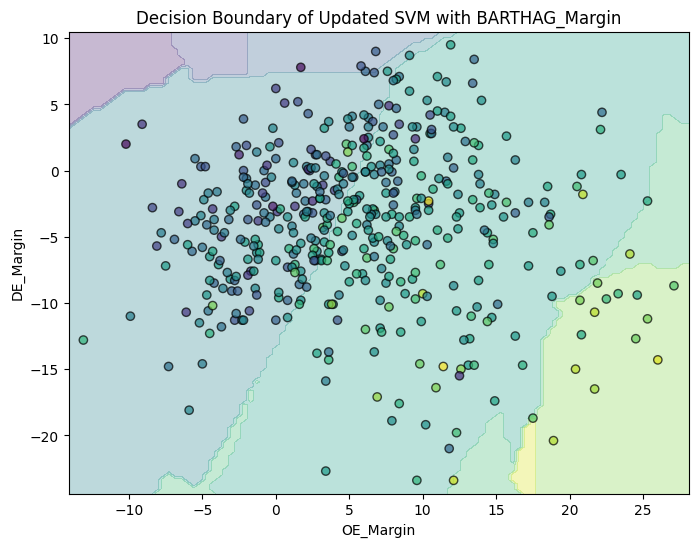

In [31]:
# Visualization of the decision boundary (for the training set)
x_min, x_max = X3_train['OE_Margin'].min() - 1, X3_train['OE_Margin'].max() + 1
y_min, y_max = X3_train['DE_Margin'].min() - 1, X3_train['DE_Margin'].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Fix BARTHAG_Margin to its mean value for visualization
Z = svm_model3.predict(np.c_[xx.ravel(), yy.ravel(), np.full(xx.ravel().shape, X3_train['BARTHAG_Margin'].mean())])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X3_train['OE_Margin'], X3_train['DE_Margin'], c=y3_train, edgecolor='k', cmap='viridis', alpha=0.7)
plt.xlabel('OE_Margin')
plt.ylabel('DE_Margin')
plt.title('Decision Boundary of Updated SVM with BARTHAG_Margin')
plt.show()

This code creates a visual representation of the SVM model's decision boundaries on the training data. For simplicity, we fix the BARTHAG_Margin feature to its mean value, allowing us to visualize the decision boundaries in a 2D space. Using matplotlib, we plot the boundaries and overlay the training data points.

## Multivariate Linear Regression with 3 Features

We will be using **statsmodels** to create a multivariate regression model using 3 features, specifically the **OE_Margin, DE_Margin, and BARTHAG_Margin**. We chose these because they were the only statistically significant features based on the p-values we found earlier. This allows us to look at whether we can accurately predict the win margin to within 3 points based on these 3 features.

In [32]:
# Building Model 
X = matchups[['OE_Margin', 'DE_Margin', 'BARTHAG_Margin']]
y = matchups['Win_Margin']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state = 42)

model = sm.OLS(y_train, X_train).fit()

model_summary = model.summary()
print(model_summary)

                                 OLS Regression Results                                
Dep. Variable:             Win_Margin   R-squared (uncentered):                   0.453
Model:                            OLS   Adj. R-squared (uncentered):              0.449
Method:                 Least Squares   F-statistic:                              131.3
Date:                Tue, 19 Nov 2024   Prob (F-statistic):                    5.56e-62
Time:                        21:06:21   Log-Likelihood:                         -1836.5
No. Observations:                 479   AIC:                                      3679.
Df Residuals:                     476   BIC:                                      3691.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

The adjusted R-squared value is 0.449, which is fine but not very good. We tried to see if adding a constant to the data would improve the model or not.

In [33]:
# Building a regression model using Offensive Efficiency, Defensive Efficiency, and BARTHAG Margins

X_cst = sm.add_constant(matchups[['OE_Margin', 'DE_Margin', 'BARTHAG_Margin']])
y_cst = matchups['Win_Margin']

X_train_cst, X_test_cst, y_train_cst, y_test_cst = train_test_split(X_cst, y_cst, test_size=0.2,random_state = 42)

model_cst = sm.OLS(y_train_cst, X_train_cst).fit()

model_cst_summary = model_cst.summary()
model_cst_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Win_Margin   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     89.57
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           5.97e-46
Time:                        21:06:21   Log-Likelihood:                -1830.0
No. Observations:                 479   AIC:                             3668.
Df Residuals:                     475   BIC:                             3685.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.7485      0.759     -3.622      0.000      -4.239      -1.257
OE_Margin          1.2056      0.165      7.295      0.000       0.881       1.530
DE_Margin         -1.2773      0.204     -6.276      0.000      -1.677      -0.877
BARTHAG_Margin   -23.7517     10.274     -2.312      0.021     -43.940      -3.563
==============================================================================
Omnibus:                        1.586   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.453   Jarque-Bera (JB):                1.394
Skew:                          -0.072   Prob(JB):                        0.498
Kurtosis:                       3.222   Cond. No.                         203.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the summary of this model, we can see that the R-squared gets worse, so adding a constant makes the model worse. We stuck to the model without a constant to predict the win margins.

In [34]:
# Using the model to predict Win Margins
predict = model.predict(X_test)

# Counting how many of the predictions are correct within 3 points of the correct margin
count = 0
predictions = list(round(predict))
test_labels = list(y_test)
for i in range(len(predictions)):
    if abs(predictions[i] - test_labels[i]) <= 3:
        count += 1
print(f"{count}/{len(test_labels)}")

35/120


The model predicted 35 out of 120 win margins correctly within 3 points. This is about 29.2%, which is a very low accuracy. To see if the predictions can be improved by adding more features, we try making a multivariate regression model with more margins.

## Multivariate Linear Regression with All Features

The last step in our process was to create a multiple linear regression model that incorporates all features from the dataset. We used a similar process to those above, creating the model with functions from statsmodels.api.


In [35]:
df = tournament_matchups.iloc[:,22:]
df['CURRENT ROUND'] = tournament_matchups['CURRENT ROUND']
df = df[df['CURRENT ROUND'] != 4][df['CURRENT ROUND'] != 2]
df = df.drop_duplicates()

features = df.drop(columns = ['GAMEID','CURRENT ROUND','Win_Margin'])
labels = df.loc[:,'Win_Margin']
train_vectors, test_vectors, train_labels, test_labels = train_test_split(features,labels,test_size=0.2,random_state = 42)
cnst = sm.add_constant(features)
multiple_mod = sm.OLS(labels,cnst)
multiple_fit = multiple_mod.fit()

print(multiple_fit.summary())

test_vectors_constant = sm.add_constant(test_vectors)
predict = multiple_fit.predict(test_vectors_constant)
count = 0
predictions = list(round(predict))
test_labels = list(test_labels)
for i in range(len(predictions)):
    if abs(predictions[i] - test_labels[i]) <= 3:
        count += 1
print(f"{count}/{len(test_labels)}")

                            OLS Regression Results                            
Dep. Variable:             Win_Margin   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     22.10
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           2.72e-52
Time:                        21:06:21   Log-Likelihood:                -2258.7
No. Observations:                 599   AIC:                             4553.
Df Residuals:                     581   BIC:                             4633.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.6447      0.735     -2.

/tmp/ipykernel_1541782/3955731985.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df['CURRENT ROUND'] != 4][df['CURRENT ROUND'] != 2]


As shown above, 31/120 game outcomes were correctly predicted within a 3 point margin of error. Although the low adjusted $R^2$ value and fraction of correctly predicted outcomes may indicate a poorly fitted model, we believe the model to be somewhat successful. March Madness games are extremely difficult to predict, so 25% accuracy is something to be extremely proud of.
